# Tensorflow implementation 01: linear model

by [Sho Nakagome](https://github.com/shonaka)

This jupyter notebook is intended to implement a simple linear model on classification problems. In this notebook, we are using fashion MNIST: https://github.com/zalandoresearch/fashion-mnist

This work is inspired by: https://github.com/Hvass-Labs/TensorFlow-Tutorials

## Imports

In [27]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

SyntaxError: invalid syntax (<ipython-input-27-084f521054b0>, line 6)

Programming environment: Python 3.6 (Anaconda)

In [18]:
tf.__version__

'1.4.0'

## Define global variables

Now let's define some global variables to be used in the code.

In [19]:
# Image related
IMG_HEIGHT = 28
IMG_WIDTH = 28
# total number of pixels in an image
IMG_TOT = IMG_HEIGHT * IMG_WIDTH
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH)
# number of classes
NUM_CLASSES = 10
# labels corresponding to the numbers
LABELS = ['t_shirt_top',  # 0
          'trouser',      # 1
          'pullover',     # 2
          'dress',        # 3
          'coat',         # 4
          'sandal',       # 5
          'shirt',        # 6
          'sneaker',      # 7
          'bag',          # 8
          'ankle_boots']  # 9

## Import data and checking the dataset

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/fashion', 
                                 source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


Now we have imported the data, let's first check the dimensions of the dataset.

In [21]:
print("Checking number of images in the dataset:")
print("\tTraining set:\t\t{0}".format(len(data.train.labels)))
print("\tValidation set:\t\t{0}".format(len(data.validation.labels)))
print("\tTest set:\t\t{0}".format(len(data.test.labels)))

Checking number of images in the dataset:
	Training set:		55000
	Validation set:		5000
	Test set:		10000


Let's also check the example labels.

In [22]:
print("Example training labels:")
print(data.train.labels[0:5])

Example training labels:
[4 0 7 9 9]


Now let's define a helper function to visualize some images and labels. This will be used later to visualize some misclassified images too.

In [23]:
def plt_image_labels(images, num_row, num_col, class_true, class_pred=None):
    """
    Plot images with true labels. If specified, predicted class too.
    :param images: the image data itself, containing pixel data.
    :param num_row: how many number of rows you want to plot.
    :param num_col: how many number of columns you want to plot.
    :param class_true: the true class labels for the images you give as the first input.
    :param class_pred: the predicted class labels. If not specified, it does not plot the labels.
    """
    # Check if the specified num_row and num_col matches the total number of images
    assert len(images) == len(class_true) == num_row * num_col
    
    # Create a subplot of num_row x num_col
    fig, axes = plt.subplots(num_row, num_col)
    fig.subplots_adjust(hspace=0.1*num_row, wspace=0.1*num_col)
    
    # for each image, plot the image and the true label. If there's predicted, plot that too.
    for i, ax in enumerate(axes.flat):
        # Plot the image
        ax.imshow(images[i].reshape(IMG_SHAPE), cmap='binary')
        
        # Show labels
        if class_pred is None:
            xlabel = "True: {0},".format(class_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(class_true[i], class_pred[i])
            
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])

Plotting few images and labels for checking.

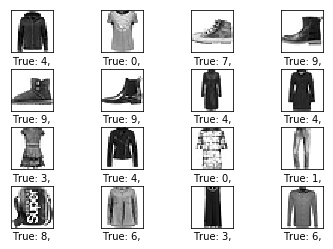

In [24]:
images = data.train.images[0:16]
class_true = data.train.labels[0:16]

# Plot using the function you made above
plt_image_labels(images=images, num_row=4, num_col=4, class_true=class_true)